In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, stdev

# data partition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LassoCV

from sklearn.feature_selection import RFE

# metric
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

# oversampling
from imblearn.over_sampling import RandomOverSampler

# Kfold
from sklearn.model_selection import StratifiedKFold

# scale
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

## Preprocessing

In [2]:
folder = '../../techscape-ecommerce/'

In [3]:
# open the dataset
df = pd.read_csv(folder+'train.csv')

In [4]:
df.head(3)

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0,0.0000,0.0667,0.0,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5,0.0217,0.0449,0.0,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0,0.0250,0.0583,0.0,Windows,4,Italy,1,Returner,0


In [5]:
# data types transformation
# Converting Date type from object to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
df["Month"]=df["Date"].map(lambda x: x.month)
df["Months_high"]=df["Month"].map(lambda x: 1 if x>7 & x<12 else 0)

## New features

In [6]:
# 0 - PC/ 1 - Mobile
dict_os = {'MacOSX': 0, 'Windows': 1, 'Android': 0, 'Ubuntu': 0, 'iOS': 0, 'Other': 0, 'Fedora': 0, 'Chrome OS':0}
df['OS_window'] = df['OS'].map(dict_os)

In [7]:
# 0 - Returner/ 1 - New_Access/ 2 - Other
dict_visitor = {'Returner': 0, 'New_Access': 1, 'Other': 0}
df['Type_of_Visitor_new'] = df['Type_of_Visitor'].map(dict_visitor)
dict_visitor = {'Returner': 1, 'New_Access': 0, 'Other': 0}
df['Type_of_Visitor_return'] = df['Type_of_Visitor'].map(dict_visitor)

In [8]:
df["Type_of_Traffic_high"]=df["Type_of_Traffic"].map(lambda x: 1 if (x in [7,8,15]) else 0)
df["Type_of_Traffic_med"]=df["Type_of_Traffic"].map(lambda x: 1 if (x in [10,11,2,5]) else 0)
df["Type_of_Traffic_high"].value_counts()

0    9528
1     471
Name: Type_of_Traffic_high, dtype: int64

In [19]:
df["is_Traffic_quality"]=df["Type_of_Traffic"].map(lambda x: 1 if (x in [2, 5, 7,8,10,11,15]) else 0)
df["is_Traffic_quality"].value_counts()

0    5608
1    4391
Name: is_Traffic_quality, dtype: int64

In [20]:
df["is_Traffic_quality_3"]=df["Type_of_Traffic"].map(lambda x :  3 if (x in [7,8,15]) else (2 if (x in [10,11,2,5]) else 0))

In [29]:
today = pd.to_datetime("2021-01-01")
df["Time_not_visited"] = df["Date"].apply(lambda x: (today-x).days)

In [31]:
df.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,...,Month,Months_high,OS_window,Type_of_Visitor_new,Type_of_Visitor_return,Type_of_Traffic_high,Type_of_Traffic_med,Time_not_visited,is_Traffic_quality,is_Traffic_quality_3
0,102863333,2020-03-21,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,...,3,0,0,0,1,0,0,286,0,0
1,103117814,2020-05-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,...,5,0,1,0,1,0,0,226,0,0
2,103201891,2020-12-04,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,...,12,1,1,0,1,0,0,28,0,0
3,103226087,2020-12-22,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,...,12,1,1,0,1,0,1,10,1,2
4,103234445,2020-11-24,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,...,11,1,1,0,1,0,0,38,0,0


## Feature Selection

In [32]:
X = df.drop('Buy', axis=1)
y = df['Buy']

# split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=5, stratify=y)

In [33]:
# define the fuction for correlation's heatmap 
def cor_heatmap(cor, ax):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1', ax=ax)
    plt.show()

In [34]:
all_train_num = X_train.join(y_train)

# Define metric and non-metric features
non_metric_features = ['Date', 'OS', 'Browser', 'Country', 'Type_of_Traffic', 'Type_of_Visitor']
metric_features = all_train_num.columns.drop(non_metric_features).to_list()

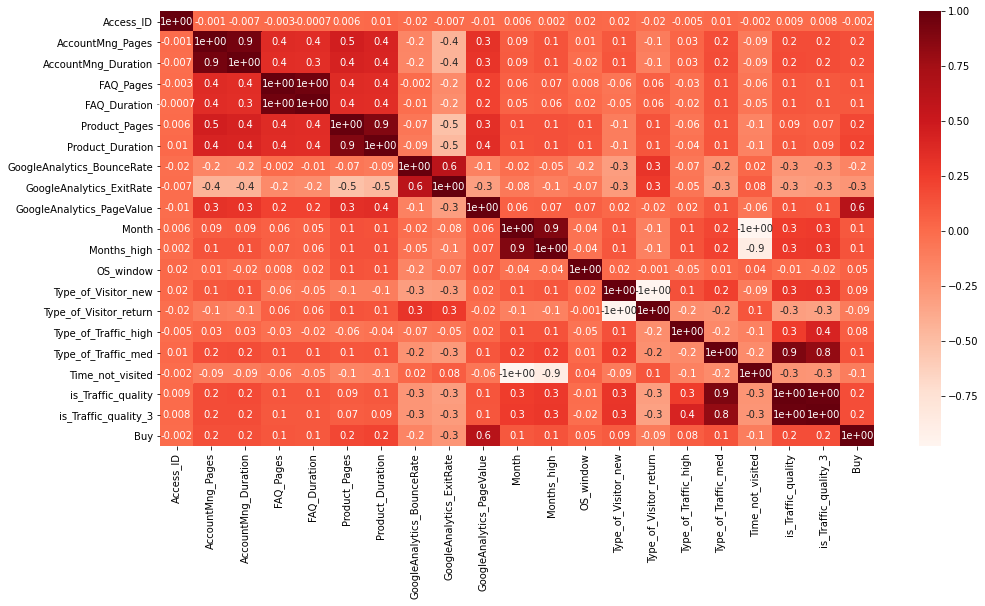

<Figure size 864x720 with 0 Axes>

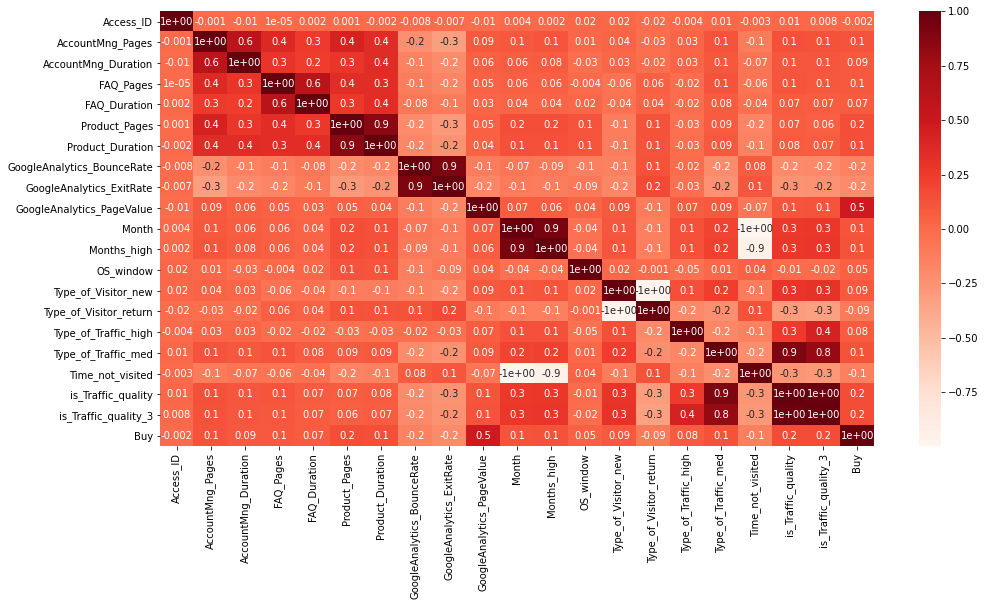

<Figure size 864x720 with 0 Axes>

In [39]:
#build correlation matrix
# method - pearson - feature and target/ linear relation
cor_pearson = all_train_num[metric_features].corr(method='pearson')

# method - spearman - rank correlation, ordering/ not linear relation
cor_spearman = all_train_num[metric_features].corr(method ='spearman')

# plot the correlations
fig, ax1 = plt.subplots(1,1, figsize=(16,8))
cor_heatmap(cor_spearman, ax1)

fig, ax1 = plt.subplots(1,1, figsize=(16,8))
cor_heatmap(cor_pearson, ax1)

## Remove Outliers

# Choosing final features

In [40]:
"""
# trashold for outliers
filters2 = (
    (df['GoogleAnalytics_PageValue']<=350)
#    &(df['GoogleAnalytics_ExitRate']<.2)
)

df_1 = df[filters2]

print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df.shape[0], 4))
"""

"\n# trashold for outliers\nfilters2 = (\n    (df['GoogleAnalytics_PageValue']<=350)\n#    &(df['GoogleAnalytics_ExitRate']<.2)\n)\n\ndf_1 = df[filters2]\n\nprint('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df.shape[0], 4))\n"

In [41]:
df.columns

Index(['Access_ID', 'Date', 'AccountMng_Pages', 'AccountMng_Duration',
       'FAQ_Pages', 'FAQ_Duration', 'Product_Pages', 'Product_Duration',
       'GoogleAnalytics_BounceRate', 'GoogleAnalytics_ExitRate',
       'GoogleAnalytics_PageValue', 'OS', 'Browser', 'Country',
       'Type_of_Traffic', 'Type_of_Visitor', 'Buy', 'Month', 'Months_high',
       'OS_window', 'Type_of_Visitor_new', 'Type_of_Visitor_return',
       'Type_of_Traffic_high', 'Type_of_Traffic_med', 'Time_not_visited',
       'is_Traffic_quality', 'is_Traffic_quality_3'],
      dtype='object')

In [11]:
# .69 score on kaggle
# df_log3 = df[["Months_high","Type_of_Visitor_new",'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue',"Buy"]]
# undersampling of length 4. 
# exit rate and page value both power transformed
# with outlier threshold of 350 only for page value

In [42]:
df_log_iryna = df[["AccountMng_Pages", "FAQ_Pages", "Product_Pages", "GoogleAnalytics_ExitRate", 
                   "GoogleAnalytics_PageValue", "Months_high", "Type_of_Visitor_new", "is_Traffic_quality", 
                   "Buy"]]

In [43]:
X = df_log_iryna.drop('Buy', axis=1)
y = df_log_iryna['Buy']

## Balance the training set - test Oversampling

In [44]:
# split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=5, stratify=y)

In [45]:
# Before Oversampling
print('X:', X_train.shape)
print('y:', y_train.shape)
y_train.value_counts()

X: (7499, 8)
y: (7499,)


0    6335
1    1164
Name: Buy, dtype: int64

In [46]:
#removing outliers after train-test
under = pd.concat([X_train,y_train],axis=1)
#under = under[filters2]

In [47]:
#balance our data - will remove negatively labeled data until the number of positives and negatives are the same. 
negative = under.loc[under.Buy==0]
positive = under.loc[under.Buy==1]
negative = negative.sample(frac=1, random_state=0)
negative_under = negative[:int(4*len(positive))]
df_under = pd.concat([positive,negative_under],axis=0)
df_under = df_under.sample(frac=1, random_state=0)

In [48]:
# After undersampling
X_train_under = df_under.drop('Buy', axis=1)
y_train_under = df_under['Buy']
y_train_under.value_counts()

0    4656
1    1164
Name: Buy, dtype: int64

In [63]:
X_train_under.shape

(5820, 8)

In [64]:
y_train_under.shape

(5820,)

# Variable power transformations after train_test_split

In [73]:
# Define metric and non-metric features
metric_features = ["AccountMng_Pages", "FAQ_Pages", "Product_Pages", "GoogleAnalytics_ExitRate", 
                   "GoogleAnalytics_PageValue"]
non_metric_features = X.columns.drop(metric_features).to_list()

In [74]:
#separate numeric and non-numeric
X_train_num = X_train_under[metric_features]
X_train_cat = X_train_under[non_metric_features]

# DO IT for validation
X_val_num = X_val[metric_features]
X_val_cat = X_val[non_metric_features]

In [75]:
#use train to power transform train and test
power = PowerTransformer().fit(X_train_num)
X_train_num_power = power.transform(X_train_num)
X_train_num_power = pd.DataFrame(X_train_num_power, columns = X_train_num.columns).set_index(X_train_num.index)

#and for validation
X_val_num_power = power.transform(X_val_num)
# Convert the array to a pandas dataframe
X_val_num_power = pd.DataFrame(X_val_num_power, columns = X_val_num.columns).set_index(X_val_num.index)
X_val_num_power.head(3)

X_train_power = pd.concat([X_train_num_power, X_train_cat], axis=1)
X_val_power = pd.concat([X_val_num_power, X_val_cat], axis=1)

# RFE

In [97]:
#no of features
nof_list=np.arange(1,8)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]

for n in range(len(nof_list)):
    model = LogisticRegression(class_weight='balanced').fit(X_train_power, y_train_under)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_power,y_train_under)
    X_val_rfe = rfe.transform(X_val_power)
    model.fit(X_train_rfe,y_train_under)
    
    score = f1_score(y_val, (rfe.predict_proba(X_val_power)[:,1]>=0.75).astype(int))
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 3
Score with 3 features: 0.662005


In [98]:
model = LogisticRegression(class_weight='balanced').fit(X_train_power, y_train_under)
rfe = RFE(estimator = model, n_features_to_select = 3)
X_rfe = rfe.fit_transform(X = X_train_power, y = y_train_under)

selected_features = pd.Series(rfe.support_, index = X_train_under.columns)
selected_features
#GoogleAnalytics_PageValue, Months_high, is_Traffic_quality

AccountMng_Pages             False
FAQ_Pages                    False
Product_Pages                False
GoogleAnalytics_ExitRate     False
GoogleAnalytics_PageValue     True
Months_high                   True
Type_of_Visitor_new          False
is_Traffic_quality            True
dtype: bool

# final model

In [254]:
#with 25% test set, undersampling of length 4, and 4 variables (df_log3)
model_log6 = LogisticRegression(class_weight='balanced').fit(X_train_power, y_train_under)

y_pred_train = model_log6.predict(X_train_power)
y_pred_val = model_log6.predict(X_val_power)
model_log6.coef_

array([[-0.15668969,  0.06493047,  0.08315608, -0.29185618,  1.58412404,
         1.15795318,  0.46698735,  0.51522492]])

In [255]:
#low precision can be improved by increasing your threshold, making your model less sensitive
y_pred_val_new_threshold = (model_log6.predict_proba(X_val_power)[:,1]>=0.7).astype(int)
print('f1_train:', f1_score(y_train_under, y_pred_train))
print(confusion_matrix(y_val, y_pred_val_new_threshold))
print('precision:', precision_score(y_val, y_pred_val_new_threshold))
print('f1_val:', f1_score(y_val, y_pred_val_new_threshold))

f1_train: 0.7088512241054614
[[1904  208]
 [  95  293]]
precision: 0.5848303393213573
f1_val: 0.6591676040494937


In [292]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=1, learning_rate=1, max_depth=1, random_state=0)
clf.fit(X_train_power, y_train_under)

GradientBoostingClassifier(learning_rate=1, max_depth=1, n_estimators=1,
                           random_state=0)

In [293]:
y_pred_train = clf.predict(X_train_power)
y_pred_val = clf.predict(X_val_power)

In [297]:
#low precision can be improved by increasing your threshold, making your model less sensitive
y_pred_val_new_threshold = (clf.predict_proba(X_val_power)[:,1]>=0.6).astype(int)
print('f1_train:', f1_score(y_train_under, y_pred_train))
print(confusion_matrix(y_val, y_pred_val_new_threshold))
print('precision:', precision_score(y_val, y_pred_val_new_threshold))
print('f1_val:', f1_score(y_val, y_pred_val_new_threshold))

f1_train: 0.7115165336374001
[[1875  237]
 [  86  302]]
precision: 0.5602968460111317
f1_val: 0.651564185544768


## Dataset for test

In [298]:
test_set = pd.read_csv(folder+'test.csv')
# test_set.set_index('Access_ID', inplace = True)

In [301]:
# select the columns for the model
#months variable
test_set['Date'] = pd.to_datetime(test_set['Date'], format='%d-%b-%y')
test_set["Month"]=test_set["Date"].map(lambda x: x.month)
test_set["Months_high"]=test_set["Month"].map(lambda x: 1 if x>7 & x<12 else 0)

# type pf visitor
dict_visitor = {'Returner': 0, 'New_Access': 1, 'Other': 0}
test_set['Type_of_Visitor_new'] = test_set['Type_of_Visitor'].map(dict_visitor)
dict_visitor = {'Returner': 1, 'New_Access': 0, 'Other': 0}
test_set['Type_of_Visitor_return'] = test_set['Type_of_Visitor'].map(dict_visitor)

#type of traffic
test_set["is_Traffic_quality"]=test_set["Type_of_Traffic"].map(lambda x: 1 if (x in [2, 5, 7,8,10,11,15]) else 0)

test = test_set[["AccountMng_Pages", "FAQ_Pages", "Product_Pages", "GoogleAnalytics_ExitRate",
                 "GoogleAnalytics_PageValue", "Months_high", "Type_of_Visitor_new", "is_Traffic_quality"]]

In [302]:
# Define metric and non-metric features
metric_features = ["AccountMng_Pages", "FAQ_Pages", "Product_Pages", "GoogleAnalytics_ExitRate", 
                   "GoogleAnalytics_PageValue"]
non_metric_features = X.columns.drop(metric_features).to_list()
test_num = test[metric_features]
test_cat = test[non_metric_features]

In [303]:
#power transform
test_num_power = power.transform(test_num)
test_num_power = pd.DataFrame(test_num_power, columns = test_num.columns).set_index(test_num.index)

test_power = pd.concat([test_num_power, test_cat], axis=1)

In [304]:
test_power.columns

Index(['AccountMng_Pages', 'FAQ_Pages', 'Product_Pages',
       'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'Months_high',
       'Type_of_Visitor_new', 'is_Traffic_quality'],
      dtype='object')

In [305]:
y_pred_new_threshold = (model_log6.predict_proba(test_power)[:,1]>=0.7).astype(int)

In [306]:
df_submission = pd.concat([test_set['Access_ID'], pd.DataFrame(columns=['Buy'], data=y_pred_new_threshold)], axis=1)

In [307]:
df_submission['Buy'].value_counts()

0    1855
1     445
Name: Buy, dtype: int64

In [309]:
df_submission.to_csv('Group17_Version_iryna.csv', index=False)